In [130]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/Melbourne_housing_FULL.csv")

In [131]:
df.drop(columns=["BuildingArea", "YearBuilt", "Propertycount", "Regionname", "Car", "CouncilArea"], axis=1, inplace=True)
df = df.dropna()

In [132]:
columns = ["Bedroom2", "Bathroom"]

for column in columns:
    df[column] = df[column].astype(int)

In [133]:
duplicated = df.duplicated(subset=("Lattitude", "Longtitude", "Date"), keep="first")
df = df[~duplicated]

In [134]:
land_eq_zero = (df["Landsize"] == 0)
df = df[~land_eq_zero]

land_size_up_threshold = 10000
gt_10000_land = (df["Landsize"] > land_size_up_threshold)
df = df[~gt_10000_land]

land_size_lo_threshold = 55
lt_55_land = (df["Landsize"] < land_size_lo_threshold)
df = df[~lt_55_land]

bed_20 = (df["Bedroom2"] == 20)
df = df[~bed_20]

bath_zero = (df["Bathroom"] == 0)
df = df[~bath_zero]

df["BedtoBath"] = df["Bedroom2"] / df["Bathroom"]

tail_heavy_columns = ["Landsize", ]
df[tail_heavy_columns] = df[tail_heavy_columns].apply(lambda x: np.log(x+1))

In [135]:
df.drop(columns=["Suburb", "Address", "Method", "SellerG", "Date", "Postcode"], axis=1, inplace=True)

In [136]:
from sklearn.model_selection import train_test_split

X = df.drop(columns="Price")
y = df["Price"]

cat_columns = ["Rooms", "Type", "Bedroom2", "Bathroom"]
X = pd.get_dummies(X, columns=cat_columns, dtype=int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [138]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_columns = ["Distance", "Landsize", "Lattitude", "Longtitude", "BedtoBath"]

scaler.fit(X_train[num_columns])
X_train[num_columns] = scaler.transform(X_train[num_columns])

In [139]:
from sklearn.ensemble import RandomForestRegressor

# These are are hyper-parameters from v5 notebook
model = RandomForestRegressor(max_depth=20,
                              min_samples_leaf=2,
                              min_samples_split=5,
                              n_estimators=200,
                              n_jobs=-1)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=200, n_jobs=-1)

## Diagnostic Plots

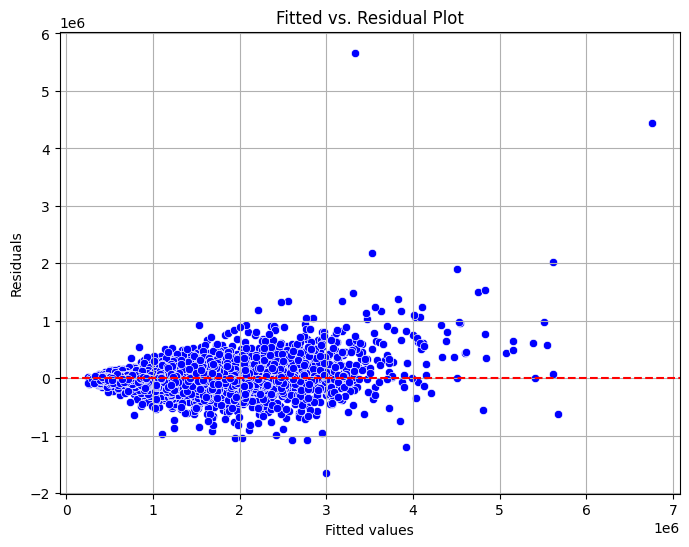

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_train)
residuals = (y_train - y_pred)

plotting_data = {'Fitted Values': y_pred, 'Residuals': residuals}
plotting_df = pd.DataFrame(plotting_data)

plt.figure(figsize=(8, 6))
sns.scatterplot(x='Fitted Values', y='Residuals', data=plotting_df, color='blue')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Fitted vs. Residual Plot')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

* The spread of the residuals seems to increase as the fitted values increase, indicating that the residuals are not evenly spread across all levels of the fitted values. Which is en expected behaviour, as housing prices span different scale of values (`Price`)
* There are a few points that are far from the main cluster of residuals, indicating potential outliers or high-leverage points. And hence these points could have a significant impact on the model's performance
* The residuals appear to be centered around zero, which is good, but the spread and presence of outliers might affect the normality of the residuals.

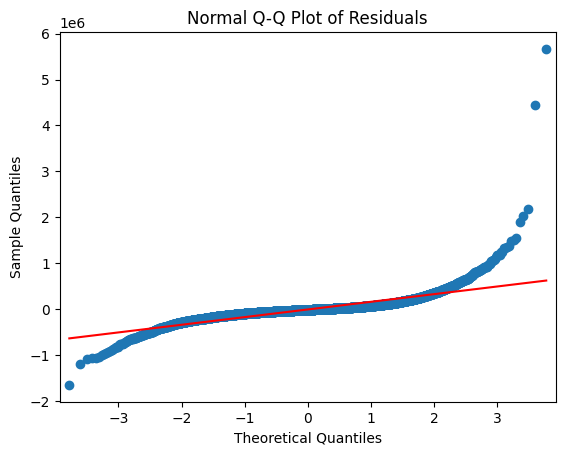

In [141]:
import statsmodels.api as sm
import scipy.stats as stats

sm.qqplot(residuals, line='s')
plt.title('Normal Q-Q Plot of Residuals')
plt.show()

* The plot shows a clear deviation from the red reference line, which represents the expected quantiles if the residuals were normally distributed.
* The residuals exhibit heavy tails, as indicated by the points deviating upwards and downwards at both ends of the plot. This suggests the presence of outliers and extreme values in the residuals.

---
The loss value and performance metrics of the above model are :<br>
**Root Mean Squared Error** - `289082.6701573245`<br>
**Mean Absolute Error** - `167567.6562103214`<br>
**R2** - `0.7991909758932563`

---

* From the Fitted Values Vs Residuals Plot, it is clear that most points of the main cluster are surrounded by `0`, however the model reported a significantly larger loss values for both **RMSE** and **MAE**
* The large errors could be due to the outlier and high-leverage points, which shall require further analysis
* From both the visualizations above, it is clear that the model performs decently well upto a `Price` value of `3,500,000`. For values beyond these values, the points are spread out from the cluster, indicating a poor performance from the model.

In [142]:
X_test_transformed = X_test.copy()
X_test_transformed[num_columns] = scaler.transform(X_test_transformed[num_columns])

y_pred_test = model.predict(X_test_transformed)
residuals_test = (y_test - y_pred_test)

test_data = X_test.copy()
test_data["residuals"] = residuals_test

In [146]:
residuals_filter = (test_data.residuals.abs() > 0.75e06)
filtered_test_data = test_data[residuals_filter]

print(f"Num points - {len(filtered_test_data)}")

correlation_matrix = filtered_test_data.corr()

correlation_matrix["residuals"][correlation_matrix["residuals"].abs() > .2]

Num points - 86


Landsize     -0.272414
Rooms_2      -0.300990
Rooms_5       0.229048
Bedroom2_2   -0.300990
Bedroom2_5    0.207332
Bathroom_5    0.238259
residuals     1.000000
Name: residuals, dtype: float64

---

When considering data points that have a absolute value greater than `0.75e06` (This value is chosen from the Fitted Values Vs Residuals Plot), a few variables show a weak positive and negative correlation with the **residual**. However, when we consider data points above and below the residual threshold, certain correlation values standout.

---

In [147]:
residuals_filter1 = (test_data.residuals > 0.75e06)
filtered_test_data1 = test_data[residuals_filter1]

print(f"Num points - {len(filtered_test_data1)}")
filtered_test_data1.head()

Num points - 56


,Distance,Landsize,Lattitude,Longtitude,BedtoBath,Rooms_1,Rooms_2,Rooms_3,Rooms_4,Rooms_5,...,Bathroom_1,Bathroom_2,Bathroom_3,Bathroom_4,Bathroom_5,Bathroom_6,Bathroom_7,Bathroom_8,Bathroom_9,residuals
166,3.3,4.997212,-37.84730,144.95510,1.500000,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1.101953e+06
14021,1.5,5.789960,-37.81330,144.98650,2.000000,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1.104360e+06
25406,10.2,7.113142,-37.82420,145.10215,1.333333,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,8.705683e+05
4281,3.5,6.100319,-37.78600,144.98640,1.500000,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1.328365e+06
15098,5.9,6.857514,-37.85905,145.03229,0.750000,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,8.568869e+05


In [148]:
correlation_matrix = filtered_test_data1.corr()

correlation_matrix["residuals"][correlation_matrix["residuals"].abs() > .2]

Landsize      0.291455
Rooms_5       0.262181
Bedroom2_5    0.247234
Bathroom_2   -0.236114
Bathroom_5    0.635811
residuals     1.000000
Name: residuals, dtype: float64

---
When considering data points above residual threshold, the correlation value among `Bathroom_5` and `residuals` is significantly higher!

---

In [149]:
residuals_filter2 = (test_data.residuals < -0.75e06)
filtered_test_data2 = test_data[residuals_filter2]

print(f"Num points - {len(filtered_test_data2)}")
filtered_test_data2.head()

Num points - 30


,Distance,Landsize,Lattitude,Longtitude,BedtoBath,Rooms_1,Rooms_2,Rooms_3,Rooms_4,Rooms_5,...,Bathroom_1,Bathroom_2,Bathroom_3,Bathroom_4,Bathroom_5,Bathroom_6,Bathroom_7,Bathroom_8,Bathroom_9,residuals
2313,5.2,8.450412,-37.76870,144.96490,1.500000,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,-1.273914e+06
16880,7.2,5.726848,-37.89507,145.00477,1.500000,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,-8.442352e+05
34077,7.7,6.876265,-37.82901,145.06714,1.500000,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,-1.314514e+06
29567,13.8,9.001346,-37.93462,145.00807,1.500000,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,-1.328703e+06
34704,1.9,6.095825,-37.83524,144.95211,1.333333,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,-1.112304e+06


In [150]:
correlation_matrix = filtered_test_data2.corr()

correlation_matrix["residuals"][correlation_matrix["residuals"].abs() > .2]

Distance      0.381198
Landsize     -0.209209
Lattitude    -0.281667
Longtitude    0.234208
Rooms_2      -0.254082
Type_h        0.610384
Type_t       -0.610384
Bedroom2_2   -0.254082
residuals     1.000000
Name: residuals, dtype: float64

---
When considering data points below residual threshold, the correlation value among `Type_t`, `Type_h`, `Distance` and `residuals` is significantly higher!

---

In [154]:
residuals_filter = (test_data.residuals.abs() < 0.75e06)
filtered_test_data = test_data[residuals_filter]

print(f"Num points - {len(filtered_test_data)}")

correlation_matrix = filtered_test_data.corr()

correlation_matrix["residuals"][correlation_matrix["residuals"].abs() > .2]

Num points - 3097


residuals    1.0
Name: residuals, dtype: float64

---
Data points present with-in the main cluster of the Residual Vs Fitted Values plot, the variables appear to not have any significant correlation with the residual!

---

## Grouped Analysis

### Distance

In [182]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

In [191]:
percentiles = [0, 25, 50, 75, 100]
bin_edges = np.percentile(test_data['Distance'], percentiles)

test_data["Distance_Bins"] = pd.cut(test_data["Distance"], bins=bin_edges, include_lowest=True)

In [198]:
for bin_label in sorted(test_data.Distance_Bins.unique()):
    bin_idx = test_data[test_data.Distance_Bins == bin_label].index
    group_subset_X = X_test_transformed.loc[bin_idx, :]
    group_subset_y = y_test[bin_idx]

    y_pred = model.predict(group_subset_X)
    rmse = root_mean_squared_error(group_subset_y, y_pred)
    mae = mean_absolute_error(group_subset_y, y_pred)
    r2 = r2_score(group_subset_y, y_pred)
    
    print(bin_label)
    print(f'Best Root Mean Squared Error: {rmse}')
    print(f'Best Mean Absolute Error: {mae}')
    print(f'Best R2 Error: {r2}')
    print(f'Mean Price Value: {group_subset_y.mean()}\n')

(1.199, 7.0]
Best Root Mean Squared Error: 353723.8124658647
Best Mean Absolute Error: 219618.92300811928
Best R2 Error: 0.761569149039325
Mean Price Value: 1328811.5061576355

(7.0, 10.5]
Best Root Mean Squared Error: 338902.8939646434
Best Mean Absolute Error: 196650.58273932632
Best R2 Error: 0.7919543606692931
Mean Price Value: 1335928.6616161617

(10.5, 14.0]
Best Root Mean Squared Error: 240643.69450776296
Best Mean Absolute Error: 147193.29804748142
Best R2 Error: 0.7935288781868723
Mean Price Value: 1045681.4159292035

(14.0, 47.3]
Best Root Mean Squared Error: 160697.82117542252
Best Mean Absolute Error: 101272.55014559282
Best R2 Error: 0.8209960306786409
Mean Price Value: 865292.8895939087



An interesting pattern appears with respect to the `Distance` variable, properties that are closer to **The Melbourne Central Business District**, appear to have higher loss value, and the loss value reduces for properties located far from the area.

### Landsize

In [200]:
percentiles = [0, 25, 50, 75, 100]
bin_edges = np.percentile(test_data['Landsize'], percentiles)

test_data["Landsize_Bins"] = pd.cut(test_data["Landsize"], bins=bin_edges, include_lowest=True)

for bin_label in sorted(test_data.Landsize_Bins.unique()):
    bin_idx = test_data[test_data.Landsize_Bins == bin_label].index
    group_subset_X = X_test_transformed.loc[bin_idx, :]
    group_subset_y = y_test[bin_idx]

    y_pred = model.predict(group_subset_X)
    rmse = root_mean_squared_error(group_subset_y, y_pred)
    mae = mean_absolute_error(group_subset_y, y_pred)
    r2 = r2_score(group_subset_y, y_pred)
    
    print(bin_label)
    print(f'Best Root Mean Squared Error: {rmse}')
    print(f'Best Mean Absolute Error: {mae}')
    print(f'Best R2 Error: {r2}')
    print(f'Mean Price Value: {group_subset_y.mean()}\n')

(4.024, 5.727]
Best Root Mean Squared Error: 202949.6150522552
Best Mean Absolute Error: 140241.4992072303
Best R2 Error: 0.8042861773222502
Mean Price Value: 1032272.2222222222

(5.727, 6.314]
Best Root Mean Squared Error: 232084.66865434404
Best Mean Absolute Error: 145988.54170170208
Best R2 Error: 0.8127634986683558
Mean Price Value: 1067707.3185840708

(6.314, 6.524]
Best Root Mean Squared Error: 245003.63091785563
Best Mean Absolute Error: 146257.95503395822
Best R2 Error: 0.8420408455795675
Mean Price Value: 1149813.174404015

(6.524, 9.194]
Best Root Mean Squared Error: 412767.59739989304
Best Mean Absolute Error: 234171.9493316394
Best R2 Error: 0.7678498816044392
Mean Price Value: 1332780.3539042822



For the variable `Landsize`, only for large values the error value appears to be high. Another observation that should be noted is that although, the `Landsize` increased, the variable `Price` does not increase significantly!
<br><br>
*Please Note - The `Landsize` values are log transformed*

### Rooms

In [212]:
category_values = [item for item in filter(lambda x: x.startswith("Rooms_"), test_data.columns)]

for value in category_values:
    bin_idx = test_data[test_data[value] == 1].index
    group_subset_X = X_test_transformed.loc[bin_idx, :]
    group_subset_y = y_test[bin_idx]

    if len(group_subset_X) == 0: continue
    y_pred = model.predict(group_subset_X)
    rmse = root_mean_squared_error(group_subset_y, y_pred)
    mae = mean_absolute_error(group_subset_y, y_pred)
    r2 = r2_score(group_subset_y, y_pred)
    
    print(value)
    print(f'Best Root Mean Squared Error: {rmse}')
    print(f'Best Mean Absolute Error: {mae}')
    print(f'Best R2 Error: {r2}')
    print(f'Mean Price Value: {group_subset_y.mean()}\n')

Rooms_1
Best Root Mean Squared Error: 185854.43450502487
Best Mean Absolute Error: 125931.1911981827
Best R2 Error: 0.7875901723994295
Mean Price Value: 622046.5116279069

Rooms_2
Best Root Mean Squared Error: 245883.75036493267
Best Mean Absolute Error: 143022.4627855855
Best R2 Error: 0.4907476718732616
Mean Price Value: 876605.1810344828

Rooms_3
Best Root Mean Squared Error: 225908.58227229468
Best Mean Absolute Error: 136617.01365354497
Best R2 Error: 0.787648846988889
Mean Price Value: 1055191.0191082803

Rooms_4
Best Root Mean Squared Error: 314999.1122844838
Best Mean Absolute Error: 204391.41137339943
Best R2 Error: 0.8174943790390412
Mean Price Value: 1385611.4565756824

Rooms_5
Best Root Mean Squared Error: 580501.709690763
Best Mean Absolute Error: 334410.193911665
Best R2 Error: 0.7392714493369699
Mean Price Value: 1830732.264516129

Rooms_6
Best Root Mean Squared Error: 514112.31169716315
Best Mean Absolute Error: 293384.4901169895
Best R2 Error: 0.7967560727251275
Mean P

Similar to earlier, as the Number of Rooms of the property increases, the `Price` of the property, as well as the loss value increases. The R2 appears to be decreasing in general, as the number of rooms increase. We might be able to expect a similar pattern with the `Bedroom2` and `Bathroom` variables as well

### Bathroom

In [215]:
category_values = [item for item in filter(lambda x: x.startswith("Bathroom_"), test_data.columns)]

for value in category_values:
    bin_idx = test_data[test_data[value] == 1].index
    group_subset_X = X_test_transformed.loc[bin_idx, :]
    group_subset_y = y_test[bin_idx]

    if len(group_subset_X) <= 2: continue
    y_pred = model.predict(group_subset_X)
    rmse = root_mean_squared_error(group_subset_y, y_pred)
    mae = mean_absolute_error(group_subset_y, y_pred)
    r2 = r2_score(group_subset_y, y_pred)
    
    print(value)
    print(f'Best Root Mean Squared Error: {rmse}')
    print(f'Best Mean Absolute Error: {mae}')
    print(f'Best R2 Error: {r2}')
    print(f'Mean Price Value: {group_subset_y.mean()}\n')

Bathroom_1
Best Root Mean Squared Error: 200241.60036481093
Best Mean Absolute Error: 125352.82142546997
Best R2 Error: 0.782174013436524
Mean Price Value: 959775.8429385687

Bathroom_2
Best Root Mean Squared Error: 282011.3822704685
Best Mean Absolute Error: 178336.53090939607
Best R2 Error: 0.7882842605902686
Mean Price Value: 1212992.7310861424

Bathroom_3
Best Root Mean Squared Error: 423524.9664922802
Best Mean Absolute Error: 281931.5051702356
Best R2 Error: 0.737854956847275
Mean Price Value: 1741332.8484848484

Bathroom_4
Best Root Mean Squared Error: 836096.1545329603
Best Mean Absolute Error: 642259.091932095
Best R2 Error: 0.7176531333869547
Mean Price Value: 2887518.5185185187

Bathroom_5
Best Root Mean Squared Error: 1836688.8919113975
Best Mean Absolute Error: 1193350.0424166422
Best R2 Error: 0.43286031661709445
Mean Price Value: 3116625.0



### Bedroom

In [220]:
category_values = [item for item in filter(lambda x: x.startswith("Bedroom2_"), test_data.columns)]

for value in category_values:
    bin_idx = test_data[test_data[value] == 1].index
    group_subset_X = X_test_transformed.loc[bin_idx, :]
    group_subset_y = y_test[bin_idx]

    if len(group_subset_X) <= 2: continue
    y_pred = model.predict(group_subset_X)
    rmse = root_mean_squared_error(group_subset_y, y_pred)
    mae = mean_absolute_error(group_subset_y, y_pred)
    r2 = r2_score(group_subset_y, y_pred)
    
    print(value)
    print(f'Best Root Mean Squared Error: {rmse}')
    print(f'Best Mean Absolute Error: {mae}')
    print(f'Best R2 Error: {r2}')
    print(f'Mean Price Value: {group_subset_y.mean()}\n')

Bedroom2_1
Best Root Mean Squared Error: 193898.63497837272
Best Mean Absolute Error: 130362.89708568479
Best R2 Error: 0.7925008960184188
Mean Price Value: 654265.9574468085

Bedroom2_2
Best Root Mean Squared Error: 241212.5023186958
Best Mean Absolute Error: 140375.77968944464
Best R2 Error: 0.5297953991815321
Mean Price Value: 889064.7829716194

Bedroom2_3
Best Root Mean Squared Error: 230607.26441244094
Best Mean Absolute Error: 139041.1595414959
Best R2 Error: 0.7851005748234765
Mean Price Value: 1060911.6025641025

Bedroom2_4
Best Root Mean Squared Error: 319561.19389373285
Best Mean Absolute Error: 207309.9109908381
Best R2 Error: 0.8182214421601801
Mean Price Value: 1388149.6054931337

Bedroom2_5
Best Root Mean Squared Error: 571995.6199843326
Best Mean Absolute Error: 322147.5311880987
Best R2 Error: 0.7385829135575608
Mean Price Value: 1797155.6357615895

Bedroom2_6
Best Root Mean Squared Error: 575828.1042160954
Best Mean Absolute Error: 328380.41736581945
Best R2 Error: 0.7

Similar to the `Rooms` variable, the property value and loss value increase as the number of `Bedrooms` and `Bathrooms` increase. In general more rooms tend to large property value and due to the limited number of datapoints, and diversity among these data points, the model fails to capture the patterns correctly

In [225]:
category_values = [item for item in filter(lambda x: x.startswith("Type_"), test_data.columns)]

for value in category_values:
    bin_idx = test_data[test_data[value] == 1].index
    group_subset_X = X_test_transformed.loc[bin_idx, :]
    group_subset_y = y_test[bin_idx]

    if len(group_subset_X) <= 2: continue
    y_pred = model.predict(group_subset_X)
    rmse = root_mean_squared_error(group_subset_y, y_pred)
    mae = mean_absolute_error(group_subset_y, y_pred)
    r2 = r2_score(group_subset_y, y_pred)
    
    print(value)
    print(f'Best Root Mean Squared Error: {rmse}')
    print(f'Best Mean Absolute Error: {mae}')
    print(f'Best R2 Error: {r2}')
    print(f'Mean Price Value: {group_subset_y.mean()}\n')

Type_h
Best Root Mean Squared Error: 296101.0783594506
Best Mean Absolute Error: 174622.9094751466
Best R2 Error: 0.8019448287905216
Mean Price Value: 1205155.11082379

Type_t
Best Root Mean Squared Error: 254098.16293870858
Best Mean Absolute Error: 142185.45919263508
Best R2 Error: 0.5230443640097673
Mean Price Value: 976004.5662100457

Type_u
Best Root Mean Squared Error: 167845.04576367338
Best Mean Absolute Error: 102987.01856037056
Best R2 Error: 0.6459646790750326
Mean Price Value: 661227.0622568093



Type_h - House/Cottage/Villa<br>
Type_u - Single Unit/Duplex<br>
Type_t - Townhouse

A very interesting pattern can be observed with the `Type` variable.
* For `Type_h` datapoints tend to have the best R2 score and they also have the largest error values! This is likely due to the property value being singificantly larger compared to the other two types.
* For `Type_u` and `Type_t`, as the property value is lesser, smaller error values and better R2 score values can be observed